In [19]:
"""
create_merged_sentences.py

Purpose:
  - Read per-page text files from data/pages (created by your PDF extraction step).
  - Split pages into sentences using spaCy.
  - For each sentence index i, create a "buffer window" consisting of sentences[i-buffer : i+buffer+1].
  - Deduplicate consecutive identical windows (sliding windows cause duplicates).
  - Compute embeddings for each merged window using sentence-transformers (all-MiniLM-L6-v2).
  - Save merged metadata to data/merged/merged_sentences.json and embeddings to data/merged/embeddings.npy.

Outputs:
  - data/merged/merged_sentences.json
  - data/merged/embeddings.npy
"""

from pathlib import Path
import json
from typing import List, Dict, Any
import numpy as np
from tqdm import tqdm

# NLP / embeddings
import spacy
from sentence_transformers import SentenceTransformer

# ----------------- CONFIG -----------------
PAGES_DIR = Path("data/pages")                    # folder containing page_001.txt ... page_094.txt
OUT_DIR = Path("data/merged")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MERGED_JSON = OUT_DIR / "merged_sentences.json"
EMBED_NPY = OUT_DIR / "embeddings.npy"

EMBED_MODEL_NAME = "all-MiniLM-L6-v2"            # recommended model (fast & good)
BUFFER_SIZE = 2                                 # ±b sentences for each merged window (tuneable)
EMBED_BATCH_SIZE = 64                            # batch size for embeddings (tuneable)
SPACY_MODEL = "en_core_web_sm"                   # spaCy model for sentence splitting

# ----------------- Utilities -----------------
def load_page_texts(pages_dir: Path) -> List[Dict[str, Any]]:
    """
    Read page files (page_###.txt) and return ordered list of dicts: { page, file, text }
    """
    page_files = sorted(pages_dir.glob("page_*.txt"))
    pages = []
    for p in page_files:
        txt = p.read_text(encoding="utf-8")
        page_num = int(p.stem.split("_")[-1])
        pages.append({"page": page_num, "file": str(p), "text": txt})
    pages.sort(key=lambda x: x["page"])
    return pages

def split_pages_to_sentences(pages: List[Dict[str, Any]], nlp) -> List[Dict[str, Any]]:
    """
    Convert pages into a list of sentence dicts:
      { sent_id, text, page, char_start (optional), char_end (optional) }
    Note: char offsets here are not used downstream but kept for traceability if needed.
    """
    sentences = []
    sid = 0
    for pg in pages:
        text = pg["text"]
        if not text or text.strip() == "":
            continue
        doc = nlp(text)
        for sent in doc.sents:
            s = sent.text.strip()
            if not s:
                continue
            sentences.append({
                "sent_id": sid,
                "text": s,
                "page": pg["page"]
            })
            sid += 1
    return sentences

def make_buffer_merged(sentences: List[Dict[str, Any]], buffer_size: int) -> List[Dict[str, Any]]:
    """
    For each sentence index i, create merged_text of sentences[i-buffer : i+buffer+1].
    Deduplicate consecutive identical merged windows (sliding overlap causes repeated windows).
    Returns merged windows with metadata:
      { merged_id, text, base_sent_ids, pages, num_words }
    """
    texts = [s["text"] for s in sentences]
    n = len(texts)
    merged = []
    prev_text = None
    merged_id = 0
    for i in range(n):
        start = max(0, i - buffer_size)
        end = min(n, i + buffer_size + 1)
        merged_text = " ".join(texts[start:end]).strip()
        if merged_text == prev_text:
            continue  # skip duplicates
        base_sent_ids = list(range(start, end))
        pages = sorted({ sentences[j]["page"] for j in base_sent_ids })
        merged.append({
            "merged_id": merged_id,
            "text": merged_text,
            "base_sent_ids": base_sent_ids,
            "pages": pages,
            "num_words": len(merged_text.split())
        })
        prev_text = merged_text
        merged_id += 1
    return merged

def compute_embeddings_texts(texts: List[str], model_name: str, batch_size: int = 64) -> np.ndarray:
    """
    Compute sentence-transformers embeddings for a list of texts and return a float32 numpy array.
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    return np.array(embeddings, dtype=np.float32)

# ----------------- Main -----------------
def main():
    print("Loading spaCy model for sentence splitting...")
    nlp = spacy.load(SPACY_MODEL)

    print(f"Reading pages from {PAGES_DIR} ...")
    pages = load_page_texts(PAGES_DIR)
    print(f"Found {len(pages)} page files.")

    print("Splitting pages into sentences (spaCy)...")
    sentences = split_pages_to_sentences(pages, nlp)
    print(f"Extracted {len(sentences)} sentences from pages.")

    print(f"Creating buffer-merged windows with buffer_size = {BUFFER_SIZE} ...")
    merged = make_buffer_merged(sentences, BUFFER_SIZE)
    print(f"Created {len(merged)} merged windows.")

    # Save initial merged JSON without embeddings (lightweight)
    # We'll add emb_index once embeddings are computed.
    for i, m in enumerate(merged):
        m["merged_id"] = int(m["merged_id"])
        m["emb_index"] = None  # placeholder

    tmp_json = MERGED_JSON.with_suffix(".partial.json")
    with tmp_json.open("w", encoding="utf-8") as fh:
        json.dump({
            "meta": {
                "spacy_model": SPACY_MODEL,
                "embed_model": EMBED_MODEL_NAME,
                "buffer_size": BUFFER_SIZE,
                "n_sentences": len(sentences),
                "n_merged": len(merged)
            },
            "merged": merged
        }, fh, indent=2, ensure_ascii=False)

    print("Computing embeddings for merged windows (sentence-transformers)...")
    texts = [m["text"] for m in merged]
    embeddings = compute_embeddings_texts(texts, EMBED_MODEL_NAME, batch_size=EMBED_BATCH_SIZE)
    print("Embeddings computed. Shape:", embeddings.shape)

    # Save embeddings numpy
    np.save(EMBED_NPY, embeddings)
    print(f"Saved embeddings -> {EMBED_NPY}")

    # update merged entries with emb_index
    for i, m in enumerate(merged):
        m["emb_index"] = int(i)
        # optionally remove very long text or keep as is for traceability

    # Save final merged_json
    with MERGED_JSON.open("w", encoding="utf-8") as fh:
        json.dump({
            "meta": {
                "spacy_model": SPACY_MODEL,
                "embed_model": EMBED_MODEL_NAME,
                "buffer_size": BUFFER_SIZE,
                "n_sentences": len(sentences),
                "n_merged": len(merged)
            },
            "merged": merged
        }, fh, indent=2, ensure_ascii=False)

    print(f"Saved merged windows metadata -> {MERGED_JSON}")
    print("Done.")

if __name__ == "__main__":
    main()


Loading spaCy model for sentence splitting...
Reading pages from data\pages ...
Found 94 page files.
Splitting pages into sentences (spaCy)...
Extracted 2270 sentences from pages.
Creating buffer-merged windows with buffer_size = 2 ...
Created 2270 merged windows.
Computing embeddings for merged windows (sentence-transformers)...


Batches: 100%|██████████| 36/36 [00:48<00:00,  1.34s/it]

Embeddings computed. Shape: (2270, 384)
Saved embeddings -> data\merged\embeddings.npy
Saved merged windows metadata -> data\merged\merged_sentences.json
Done.


In [9]:
# semantic_chunker.py
import json
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
from tqdm import tqdm
from math import ceil

from transformers import AutoTokenizer
import numpy.linalg as la

# ---------- CONFIG ----------
MERGED_JSON = Path("data/merged/merged_sentences.json")
EMBED_NPY = Path("data/merged/embeddings.npy")

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CHUNKS_JSON = OUT_DIR / "chunks.json"
CHUNK_EMB_NPY = OUT_DIR / "chunks_embeddings.npy"

# Semantic chunking params (tuneable)
THETA_SIM = 0.86       # similarity threshold (cosine similarity)
TMAX = 1024                 # max tokens per chunk (assignment)
SUB_CHUNK_SIZE = 128        # token size for subchunks
SUB_OVERLAP = 128           # token overlap for subchunks

# Tokenizer (used to count tokens and reconstruct subchunk text)
TOKENIZER_NAME = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(
    TOKENIZER_NAME,
    use_fast=True,
    model_max_length=10_000_000,
    truncation=False
)



# ---------- helpers ----------
def load_merged(merged_json_path: Path) -> List[Dict[str, Any]]:
    with merged_json_path.open("r", encoding="utf-8") as fh:
        j = json.load(fh)
    merged = j["merged"]
    return merged, j.get("meta", {})

def load_embeddings(emb_path: Path) -> np.ndarray:
    return np.load(str(emb_path))

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    na = la.norm(a)
    nb = la.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

def group_adjacent_by_threshold(embeddings: np.ndarray, theta: float) -> List[List[int]]:
    """
    Given embeddings of merged windows (shape [N, D]),
    compute cosine similarity between adjacent windows and group indices into chunks:
    - start at idx 0
    - while sim(i, i+1) >= theta => keep same chunk
    - else boundary
    Returns list of chunk index lists, e.g. [[0,1,2], [3,4], ...]
    """
    N = embeddings.shape[0]
    if N == 0:
        return []
    chunks = []
    current = [0]
    for i in range(N - 1):
        s = cosine_sim(embeddings[i], embeddings[i+1])
        if s >= theta:
            current.append(i+1)
        else:
            chunks.append(current)
            current = [i+1]
    if current:
        chunks.append(current)
    return chunks

def tokens_from_text(text: str) -> List[int]:
    return tokenizer.encode(text, add_special_tokens=False)

def text_from_token_ids(token_ids: List[int]) -> str:
    return tokenizer.decode(token_ids, clean_up_tokenization_spaces=True)

def split_tokens_into_subchunks(token_ids: List[int], size: int, overlap: int) -> List[Dict[str, Any]]:
    """
    Split list of token ids into windows of length <= size with given overlap (in tokens).
    Returns list of dicts: { 'token_start', 'token_end', 'token_ids', 'text', 'num_tokens' }
    """
    if size <= 0:
        raise ValueError("size must be > 0")
    if overlap >= size:
        # If overlap equals size, step will be zero; we force overlap < size by reducing overlap
        overlap = int(size * 0.5)
    step = size - overlap
    out = []
    total = len(token_ids)
    i = 0
    while i < total:
        j = min(i + size, total)
        window = token_ids[i:j]
        out.append({
            "token_start": i,
            "token_end": j,
            "token_ids": window,
            "text": text_from_token_ids(window),
            "num_tokens": len(window)
        })
        if j == total:
            break
        i += step
    return out

def mean_embedding_of_indices(embeddings: np.ndarray, indices: List[int]) -> np.ndarray:
    if len(indices) == 0:
        return np.zeros((embeddings.shape[1],), dtype=np.float32)
    return np.mean(embeddings[indices, :], axis=0)

# ---------- main pipeline ----------
def build_chunks(merged_json=MERGED_JSON,
                 embed_npy=EMBED_NPY,
                 theta=THETA_SIM,
                 Tmax=TMAX,
                 sub_size=SUB_CHUNK_SIZE,
                 sub_overlap=SUB_OVERLAP):
    print("Loading merged windows metadata:", merged_json)
    merged, meta = load_merged(merged_json)
    print("Loading embeddings:", embed_npy)
    emb = load_embeddings(embed_npy)
    assert emb.shape[0] == len(merged), "Embeddings count and merged windows count mismatch"

    print(f"Total merged windows: {len(merged)}; embedding dim: {emb.shape[1]}")
    print(f"Grouping adjacent merged windows with theta={theta} ...")
    groups = group_adjacent_by_threshold(emb, theta)
    print(f"Produced {len(groups)} semantic chunks (pre-token-split).")

    chunks_out = []
    chunk_embeddings = []
    for cid, group_inds in enumerate(tqdm(groups, desc="chunks")):
        # Build full chunk text = concatenation of merged windows in order
        texts = [ merged[idx]["text"] for idx in group_inds ]
        chunk_text = " ".join(texts).strip()
        pages = sorted({ p for idx in group_inds for p in merged[idx]["pages"] })
        num_tokens = len(tokens_from_text(chunk_text))
        # compute chunk embedding as mean of member merged embeddings
        chunk_emb = mean_embedding_of_indices(emb, group_inds).astype(np.float32)
        subchunks = []
        if num_tokens <= Tmax:
            # single chunk
            subchunks = [{
                "text": chunk_text,
                "tokens": num_tokens,
                "token_ids": tokens_from_text(chunk_text),
                "token_start": 0,
                "token_end": num_tokens
            }]
        else:
            # split into token-level overlapping subchunks
            token_ids = tokens_from_text(chunk_text)
            windows = split_tokens_into_subchunks(token_ids, size=sub_size, overlap=sub_overlap)
            # windows entries already have decoded text and num_tokens
            subchunks = []
            for w in windows:
                subchunks.append({
                    "text": w["text"],
                    "tokens": w["num_tokens"],
                    "token_start": w["token_start"],
                    "token_end": w["token_end"]
                })

        is_container = num_tokens > Tmax

        chunks_out.append({
            "chunk_id": cid,
            "merged_ids": group_inds,
            "pages": pages,
            "text": chunk_text if not is_container else None,
            "tokens": num_tokens,
            "subchunks": subchunks,
            "is_container": is_container,   # ⭐ IMPORTANT FIX
            "emb_index": cid
        })

        chunk_embeddings.append(chunk_emb)

    # Save chunk embeddings array
    chunk_embeddings = np.vstack(chunk_embeddings) if len(chunk_embeddings) > 0 else np.zeros((0, emb.shape[1]), dtype=np.float32)
    np.save(CHUNK_EMB_NPY, chunk_embeddings)
    print(f"Saved chunk embeddings -> {CHUNK_EMB_NPY} (shape {chunk_embeddings.shape})")

    # Remove token_ids from JSON export to keep it small (we reconstructed text already)
    # and ensure JSON-serializable embeddings (we saved separately)
    for ch in chunks_out:
        for sc in ch["subchunks"]:
            # subchunk text exists; keep it. Do not include token arrays.
            if "token_ids" in sc:
                sc.pop("token_ids", None)
    # Save chunks JSON (without numeric embeddings)
    with CHUNKS_JSON.open("w", encoding="utf-8") as fh:
        json.dump({
            "meta": {
                "theta_sim": theta,
                "Tmax": Tmax,
                "sub_chunk_size": sub_size,
                "sub_overlap": sub_overlap,
                "tokenizer": TOKENIZER_NAME,
                "n_merged": len(merged),
                "n_chunks": len(chunks_out)
            },
            "chunks": chunks_out
        }, fh, indent=2, ensure_ascii=False)

    print(f"Saved chunks metadata -> {CHUNKS_JSON}")
    print("Done.")
    return CHUNKS_JSON, CHUNK_EMB_NPY

if __name__ == "__main__":
    build_chunks()


Loading merged windows metadata: data\merged\merged_sentences.json
Loading embeddings: data\merged\embeddings.npy
Total merged windows: 2270; embedding dim: 384
Grouping adjacent merged windows with theta=0.86 ...
Produced 746 semantic chunks (pre-token-split).


chunks: 100%|██████████| 746/746 [00:02<00:00, 310.59it/s]

Saved chunk embeddings -> data\processed\chunks_embeddings.npy (shape (746, 384))
Saved chunks metadata -> data\processed\chunks.json
Done.


In [10]:
"""
Chunk & Merged-Sentence Quality Analysis Script
-----------------------------------------------
Performs ALL of the following:

A) Deep semantic quality check of sample chunks
B) Histogram visualization of chunk sizes
C) Statistical distribution of chunk lengths
D) Auto-generated quality report (printed + saved)
E) Embedding strategy comparison (mean vs weighted)

Also:
- Quality check of merged windows
"""

import json
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm

# ---------------- CONFIG ----------------
MERGED_JSON = Path("data/merged/merged_sentences.json")
MERGED_EMB = Path("data/merged/embeddings.npy")
CHUNKS_JSON = Path("data/processed/chunks.json")
CHUNK_EMB = Path("data/processed/chunks_embeddings.npy")

REPORT_FILE = Path("data/processed/chunk_quality_report.txt")
TOKENIZER_NAME = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

# ---------------- UTILS ----------------
def cosine_sim(a, b):
    if norm(a) == 0 or norm(b) == 0:
        return 0
    return float(np.dot(a, b) / (norm(a) * norm(b)))

def weighted_mean_embedding(indices, embeddings):
    """
    Weighted embedding using (1 / chunk index distance)
    Example: closer merged windows contribute more.
    """
    if len(indices) == 1:
        return embeddings[indices[0]]

    weights = np.array([1 / (i + 1) for i in range(len(indices))])
    weights = weights / weights.sum()
    vecs = embeddings[indices, :]
    return np.sum(vecs * weights[:, None], axis=0)

# ---------------- LOAD FILES ----------------
with open(MERGED_JSON, "r", encoding="utf-8") as f:
    merged_data = json.load(f)

merged = merged_data["merged"]
merged_embeddings = np.load(MERGED_EMB)

with open(CHUNKS_JSON, "r", encoding="utf-8") as f:
    chunk_data = json.load(f)

chunks = chunk_data["chunks"]
chunk_embeddings = np.load(CHUNK_EMB)

# ---------------- MERGED SENTENCE QUALITY ----------------
avg_words = sum(m["num_words"] for m in merged) / len(merged)
largest_window = max(merged, key=lambda m: m["num_words"])

print("\n===== MERGED SENTENCE QUALITY =====")
print(f"Total merged windows: {len(merged)}")
print(f"Average words per window: {avg_words:.2f}")
print(f"Largest window word count: {largest_window['num_words']}")
print(f"Pages: {largest_window['pages']}")
print("Sample text:", largest_window["text"][:400], "...\n")

# ---------------- CHUNK SIZE DISTRIBUTION ----------------
chunk_sizes = [ch["tokens"] for ch in chunks]

print("===== CHUNK SIZE STATISTICS =====")
print(f"Total chunks: {len(chunk_sizes)}")
print(f"Mean: {np.mean(chunk_sizes):.2f}")
print(f"Median: {np.median(chunk_sizes):.2f}")
print(f"Min: {np.min(chunk_sizes)}")
print(f"Max: {np.max(chunk_sizes)}")
print(f"Chunks > 1024 tokens (should be ~0): {sum(np.array(chunk_sizes) > 1024)}\n")

# ---------------- HISTOGRAM VISUALIZATION ----------------
plt.figure(figsize=(10, 6))
sns.histplot(chunk_sizes, bins=40, kde=True)
plt.title("Chunk Token Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("data/processed/chunk_length_histogram.png")
plt.close()

print("Histogram saved to: data/processed/chunk_length_histogram.png\n")

# ---------------- SAMPLE CHUNK QUALITY CHECK ----------------
print("===== SAMPLE CHUNK SEMANTIC CHECK =====")
for idx in [0, 1, 2, 3, 4]:
    ch = chunks[idx]
    print(f"\n--- CHUNK {idx} ---")
    print(f"Token count: {ch['tokens']}")
    print(f"Pages: {ch['pages']}")
    print("Sample subchunk text:", ch["subchunks"][0]["text"][:300], "...")
    if ch["tokens"] > 1024:
        print("⚠ Oversized chunk detected (should be split more).")

# ---------------- EMBEDDING STRATEGY TEST ----------------
embedding_diffs = []

print("\n===== EMBEDDING STRATEGY TEST (MEAN vs WEIGHTED) =====")
for ch in chunks[:50]:  # test on first 50 chunks
    ids = ch["merged_ids"]
    mean_emb = np.mean(merged_embeddings[ids], axis=0)
    weighted_emb = weighted_mean_embedding(ids, merged_embeddings)

    diff = cosine_sim(mean_emb, weighted_emb)
    embedding_diffs.append(diff)

print(f"Average cosine similarity between mean & weighted embeddings: {np.mean(embedding_diffs):.4f}")
print("If this value is near 1.0 → mean embedding is sufficient.\n")

# ---------------- GENERATE QUALITY REPORT ----------------
with open(REPORT_FILE, "w", encoding="utf-8") as f:
    f.write("=== CHUNK QUALITY REPORT ===\n\n")
    f.write("MERGED SENTENCE QUALITY:\n")
    f.write(f"- Total merged windows: {len(merged)}\n")
    f.write(f"- Avg words per window: {avg_words:.2f}\n")
    f.write(f"- Largest window: {largest_window['num_words']} words\n\n")

    f.write("CHUNK DISTRIBUTION:\n")
    f.write(f"- Total chunks: {len(chunk_sizes)}\n")
    f.write(f"- Mean tokens: {np.mean(chunk_sizes):.2f}\n")
    f.write(f"- Median tokens: {np.median(chunk_sizes):.2f}\n")
    f.write(f"- Chunks >1024 tokens: {sum(np.array(chunk_sizes) > 1024)}\n\n")

    f.write("EMBEDDING STRATEGY TEST:\n")
    f.write(f"- Mean cosine similarity between mean & weighted: {np.mean(embedding_diffs):.4f}\n")
    f.write("\nReport Complete.\n")

print("Quality report saved to:", REPORT_FILE)
print("\n=== DONE ===")



===== MERGED SENTENCE QUALITY =====
Total merged windows: 2270
Average words per window: 103.32
Largest window word count: 271
Pages: [76]
Sample text: I would therefore like, before I close, to place before the Hindus, if they will allow me, some questions which I regard as vital and invite them seriously to consider the same. In the first place, the Hindus must consider whether it is sufficient to take the placid view of the anthropologist that there is nothing to be said about the beliefs, habits, morals and outlooks on life, which obtain amon ...

===== CHUNK SIZE STATISTICS =====
Total chunks: 746
Mean: 385.49
Median: 231.50
Min: 28
Max: 2519
Chunks > 1024 tokens (should be ~0): 53

Histogram saved to: data/processed/chunk_length_histogram.png

===== SAMPLE CHUNK SEMANTIC CHECK =====

--- CHUNK 0 ---
Token count: 356
Pages: [1, 3]
Sample subchunk text: CASTES IN INDIA Their Mechanism, Genesis and Development Paper read before the Anthropology Seminar of Dr. A. A. Goldenweizer at 

In [13]:
# src/graph/entity_extractor.py

import json
from pathlib import Path
import spacy
from tqdm import tqdm

# ---------- CONFIG ----------
CHUNKS_JSON = Path("data/processed/chunks.json")
OUT_DIR = Path("data/graph")
OUT_DIR.mkdir(parents=True, exist_ok=True)
ENTITIES_JSON = OUT_DIR / "entities.json"

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Entity labels we care about (filter noise)
VALID_ENTITY_LABELS = {
    "DATE",
    "PERSON",
    "ORG",
    "GPE",
    "LOC",
    "EVENT",
    "NORP",
    "LAW",
    "WORK_OF_ART"
}

def extract_entities():
    with CHUNKS_JSON.open("r", encoding="utf-8") as f:
        chunks_data = json.load(f)

    chunks = chunks_data["chunks"]
    entities = []

    print("Extracting entities from subchunks...")

    for chunk in tqdm(chunks):
        chunk_id = chunk["chunk_id"]
        pages = chunk["pages"]

        for sub_idx, sub in enumerate(chunk["subchunks"]):
            text = sub["text"]
            if not text.strip():
                continue

            doc = nlp(text)

            for ent in doc.ents:
                if ent.label_ not in VALID_ENTITY_LABELS:
                    continue

                entity_record = {
                    "entity": ent.text.strip(),
                    "label": ent.label_,
                    "chunk_id": chunk_id,
                    "subchunk_id": sub_idx,
                    "pages": pages
                }
                entities.append(entity_record)

    with ENTITIES_JSON.open("w", encoding="utf-8") as f:
        json.dump(entities, f, indent=2, ensure_ascii=False)

    print(f"Saved {len(entities)} entities → {ENTITIES_JSON}")

if __name__ == "__main__":
    extract_entities()


Extracting entities from subchunks...


100%|██████████| 746/746 [00:55<00:00, 13.55it/s]


Saved 13282 entities → data\graph\entities.json


In [14]:
import json

with open("data/graph/entities.json", "r", encoding="utf-8") as f:
    ents = json.load(f)

print("Total entities:", len(ents))
print("Sample:")
for e in ents[:50]:
    print(e)


Total entities: 13282
Sample:
{'entity': 'Genesis', 'label': 'ORG', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'Development Paper', 'label': 'ORG', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'the Anthropology Seminar of Dr. A. A. Goldenweizer', 'label': 'EVENT', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'The Columbia University', 'label': 'ORG', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'New York', 'label': 'GPE', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'U.S.A.', 'label': 'GPE', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': '9th May 1916', 'label': 'DATE', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'Indian Antiquary', 'label': 'PERSON', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'May 1917', 'label': 'DATE', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}
{'entity': 'Genesis', 'label': 'ORG', 'chunk_id': 0, 'subchunk_id': 0, 'pages': [1, 3]}

In [15]:
# src/graph/relation_extractor.py

import json
from pathlib import Path
import spacy
from tqdm import tqdm

# ---------- CONFIG ----------
CHUNKS_JSON = Path("data/processed/chunks.json")
ENTITIES_JSON = Path("data/graph/entities.json")

OUT_DIR = Path("data/graph")
OUT_DIR.mkdir(parents=True, exist_ok=True)
RELATIONS_JSON = OUT_DIR / "relations.json"

# Load spaCy
nlp = spacy.load("en_core_web_sm")

# Dependency labels we consider meaningful
SUBJECT_DEPS = {"nsubj", "nsubjpass"}
OBJECT_DEPS = {"dobj", "pobj", "attr"}

def load_entities_by_location(entities):
    """
    Index entities by (chunk_id, subchunk_id)
    """
    ent_map = {}
    for e in entities:
        key = (e["chunk_id"], e["subchunk_id"])
        ent_map.setdefault(key, set()).add(e["entity"])
    return ent_map

def extract_relations():
    # Load data
    with CHUNKS_JSON.open("r", encoding="utf-8") as f:
        chunks = json.load(f)["chunks"]

    with ENTITIES_JSON.open("r", encoding="utf-8") as f:
        entities = json.load(f)

    entity_lookup = load_entities_by_location(entities)
    relations = []

    print("Extracting relations from subchunks...")

    for chunk in tqdm(chunks):
        chunk_id = chunk["chunk_id"]
        pages = chunk["pages"]

        for sub_idx, sub in enumerate(chunk["subchunks"]):
            key = (chunk_id, sub_idx)
            if key not in entity_lookup:
                continue

            text = sub["text"]
            if not text.strip():
                continue

            doc = nlp(text)
            known_entities = entity_lookup[key]

            # Deduplicate relations per subchunk
            seen_triples = set()

            for token in doc:
                if token.dep_ not in SUBJECT_DEPS:
                    continue

                subj = token.text
                head = token.head  # verb

                # Normalize relation
                relation = head.lemma_.strip().lower()
                if not relation.isalpha():
                    continue

                for child in head.children:
                    if child.dep_ not in OBJECT_DEPS:
                        continue

                    obj = child.text

                    # Entity grounding
                    if subj not in known_entities or obj not in known_entities:
                        continue

                    # ❌ Remove self-loops
                    if subj == obj:
                        continue

                    triple = (subj, relation, obj)
                    if triple in seen_triples:
                        continue

                    seen_triples.add(triple)

                    relations.append({
                        "subject": subj,
                        "relation": relation,
                        "object": obj,
                        "chunk_id": chunk_id,
                        "subchunk_id": sub_idx,
                        "pages": pages
                    })

    with RELATIONS_JSON.open("w", encoding="utf-8") as f:
        json.dump(relations, f, indent=2, ensure_ascii=False)

    print(f"Saved {len(relations)} relations → {RELATIONS_JSON}")

if __name__ == "__main__":
    extract_relations()


Extracting relations from subchunks...


100%|██████████| 746/746 [00:48<00:00, 15.52it/s]

Saved 109 relations → data\graph\relations.json


In [16]:
import json
from collections import Counter

with open("data/graph/relations.json", "r", encoding="utf-8") as f:
    rels = json.load(f)

print("Total relations:", len(rels))

# 1. Self-loops
self_loops = [r for r in rels if r["subject"] == r["object"]]
print("\nSelf-loop relations:", len(self_loops))
for r in self_loops[:20]:
    print(r)

# 2. Most common relation verbs
rel_counter = Counter(r["relation"] for r in rels)
print("\nTop 20 relation verbs:")
for rel, cnt in rel_counter.most_common(20):
    print(rel, cnt)

# 3. Relations with very short entities
short_entity_rels = [
    r for r in rels
    if len(r["subject"]) <= 3 or len(r["object"]) <= 3
]
print("\nRelations with very short entities:", len(short_entity_rels))
for r in short_entity_rels[:10]:
    print(r)

# 4. Relations where relation is a stopword-like verb
BAD_RELATIONS = {"be", "have", "do", "say", "make", "use", "get"}
bad_rel_rels = [r for r in rels if r["relation"] in BAD_RELATIONS]
print("\nRelations with weak verbs:", len(bad_rel_rels))
for r in bad_rel_rels[:10]:
    print(r)


Total relations: 109

Self-loop relations: 0

Top 20 relation verbs:
support 21
be 20
permit 17
elect 10
take 10
get 8
annihilate 5
observe 3
follow 3
style 2
criticise 2
kill 2
flatter 2
command 2
create 1
compel 1

Relations with very short entities: 3
{'subject': 'Religion', 'relation': 'be', 'object': 'Law', 'chunk_id': 570, 'subchunk_id': 0, 'pages': [74]}
{'subject': 'Religion', 'relation': 'be', 'object': 'Law', 'chunk_id': 571, 'subchunk_id': 0, 'pages': [74]}
{'subject': 'Religion', 'relation': 'be', 'object': 'Law', 'chunk_id': 572, 'subchunk_id': 0, 'pages': [74, 75]}

Relations with weak verbs: 28
{'subject': 'Antyaja', 'relation': 'be', 'object': 'Guru', 'chunk_id': 217, 'subchunk_id': 1, 'pages': [35]}
{'subject': 'Antyaja', 'relation': 'be', 'object': 'Guru', 'chunk_id': 217, 'subchunk_id': 2, 'pages': [35]}
{'subject': 'Antyaja', 'relation': 'be', 'object': 'Guru', 'chunk_id': 217, 'subchunk_id': 3, 'pages': [35]}
{'subject': 'Antyaja', 'relation': 'be', 'object': 'Guru

In [17]:
# src/graph/graph_builder.py

import json
from pathlib import Path
import networkx as nx
from collections import defaultdict
from tqdm import tqdm
import pickle

# ---------- CONFIG ----------
ENTITIES_JSON = Path("data/graph/entities.json")
RELATIONS_JSON = Path("data/graph/relations.json")

OUT_DIR = Path("data/graph")
OUT_DIR.mkdir(parents=True, exist_ok=True)

GRAPH_PATH = OUT_DIR / "knowledge_graph.gpickle"
STATS_PATH = OUT_DIR / "graph_stats.json"

def build_knowledge_graph():
    # Load data
    with ENTITIES_JSON.open("r", encoding="utf-8") as f:
        entities = json.load(f)

    with RELATIONS_JSON.open("r", encoding="utf-8") as f:
        relations = json.load(f)

    print("Building Knowledge Graph...")

    G = nx.DiGraph()

    # ---- Add Nodes ----
    entity_meta = defaultdict(lambda: {
        "labels": set(),
        "pages": set(),
        "chunks": set()
    })

    for e in entities:
        name = e["entity"]
        entity_meta[name]["labels"].add(e["label"])
        entity_meta[name]["pages"].update(e["pages"])
        entity_meta[name]["chunks"].add(e["chunk_id"])

    for entity, meta in entity_meta.items():
        G.add_node(
            entity,
            labels=list(meta["labels"]),
            pages=sorted(meta["pages"]),
            chunks=sorted(meta["chunks"])
        )

    # ---- Add Edges ----
    edge_counter = defaultdict(int)
    edge_meta = defaultdict(lambda: {
        "pages": set(),
        "chunks": set()
    })

    for r in relations:
        key = (r["subject"], r["relation"], r["object"])
        edge_counter[key] += 1
        edge_meta[key]["pages"].update(r["pages"])
        edge_meta[key]["chunks"].add(r["chunk_id"])

    for (subj, rel, obj), weight in edge_counter.items():
        if subj not in G or obj not in G:
            continue

        G.add_edge(
            subj,
            obj,
            relation=rel,
            weight=weight,
            pages=sorted(edge_meta[(subj, rel, obj)]["pages"]),
            chunks=sorted(edge_meta[(subj, rel, obj)]["chunks"])
        )

    with open(GRAPH_PATH, "wb") as f:
        pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)

    # ---- Save Stats ----
    stats = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "num_relations_raw": len(relations),
        "num_entities_raw": len(entities),
        "graph_density": nx.density(G)
    }

    with STATS_PATH.open("w", encoding="utf-8") as f:
        json.dump(stats, f, indent=2)

    print("Knowledge Graph built successfully.")
    print("Nodes:", stats["num_nodes"])
    print("Edges:", stats["num_edges"])
    print("Saved graph →", GRAPH_PATH)
    print("Saved stats →", STATS_PATH)

    return G

if __name__ == "__main__":
    build_knowledge_graph()


Building Knowledge Graph...
Knowledge Graph built successfully.
Nodes: 617
Edges: 20
Saved graph → data\graph\knowledge_graph.gpickle
Saved stats → data\graph\graph_stats.json


In [18]:
import pickle

with open("data/graph/knowledge_graph.gpickle", "rb") as f:
    G = pickle.load(f)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 617
Edges: 20


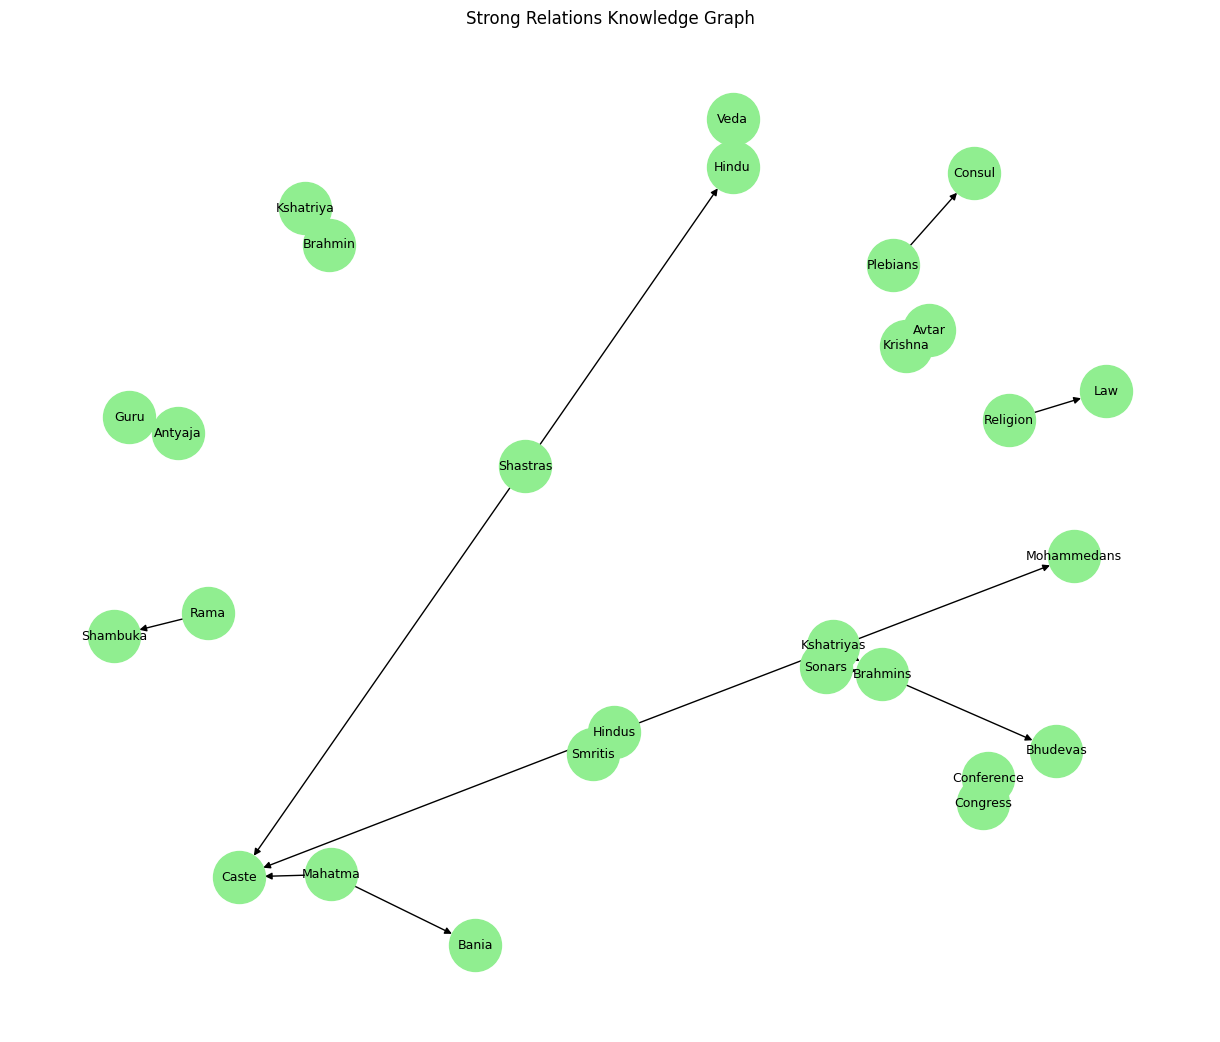

In [19]:
# Filter strong edges
strong_edges = [
    (u, v, d) for u, v, d in G.edges(data=True)
    if d.get("weight", 1) >= 2
]

H = nx.DiGraph()
H.add_edges_from(
    [(u, v, d) for u, v, d in strong_edges]
)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, seed=42)

nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=1400,
    node_color="lightgreen",
    font_size=9,
    arrows=True
)

plt.title("Strong Relations Knowledge Graph")
plt.show()


In [20]:
# src/graph/add_cooccurrence_edges.py

import json
import pickle
from pathlib import Path
from collections import defaultdict
import itertools
import networkx as nx
from tqdm import tqdm

# ---------- CONFIG ----------
GRAPH_PATH = Path("data/graph/knowledge_graph.gpickle")
ENTITIES_JSON = Path("data/graph/entities.json")

OUT_PATH = Path("data/graph/knowledge_graph_dense.gpickle")

def add_cooccurrence_edges():
    # Load graph
    with open(GRAPH_PATH, "rb") as f:
        G = pickle.load(f)

    # Load entities
    with ENTITIES_JSON.open("r", encoding="utf-8") as f:
        entities = json.load(f)

    # Group entities by chunk
    chunk_entities = defaultdict(set)
    for e in entities:
        chunk_entities[e["chunk_id"]].add(e["entity"])

    print("Adding co-occurrence edges...")

    cooc_counter = defaultdict(int)

    for ents in tqdm(chunk_entities.values()):
        if len(ents) < 2:
            continue
        for a, b in itertools.combinations(sorted(ents), 2):
            cooc_counter[(a, b)] += 1

    # Add edges
    for (a, b), weight in cooc_counter.items():
        if not G.has_node(a) or not G.has_node(b):
            continue

        if G.has_edge(a, b):
            # Edge already exists (relation edge)
            G[a][b]["weight"] += weight
            G[a][b]["relation"] += "|CO_OCCURS"
        else:
            G.add_edge(
                a,
                b,
                relation="CO_OCCURS",
                weight=weight
            )

    # Save dense graph
    with open(OUT_PATH, "wb") as f:
        pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)

    print("Dense graph saved →", OUT_PATH)
    print("Nodes:", G.number_of_nodes())
    print("Edges:", G.number_of_edges())

if __name__ == "__main__":
    add_cooccurrence_edges()


Adding co-occurrence edges...


100%|██████████| 643/643 [00:00<00:00, 169672.06it/s]

Dense graph saved → data\graph\knowledge_graph_dense.gpickle
Nodes: 617
Edges: 4948


In [21]:
import pickle
import networkx as nx

with open("data/graph/knowledge_graph_dense.gpickle", "rb") as f:
    G = pickle.load(f)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", round(avg_degree, 2))

# Top hubs
print("\nTop 10 nodes by degree:")
for n, d in sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]:
    print(n, d)


Nodes: 617
Edges: 4948
Average degree: 16.04

Top 10 nodes by degree:
Hindus 287
Hindu 266
Caste 260
India 202
Brahmins 120
Shastras 111
Brahmin 100
Mahatma 95
the Caste System 83
the Hindu Society 68


Nodes: 617 Edges: 4948


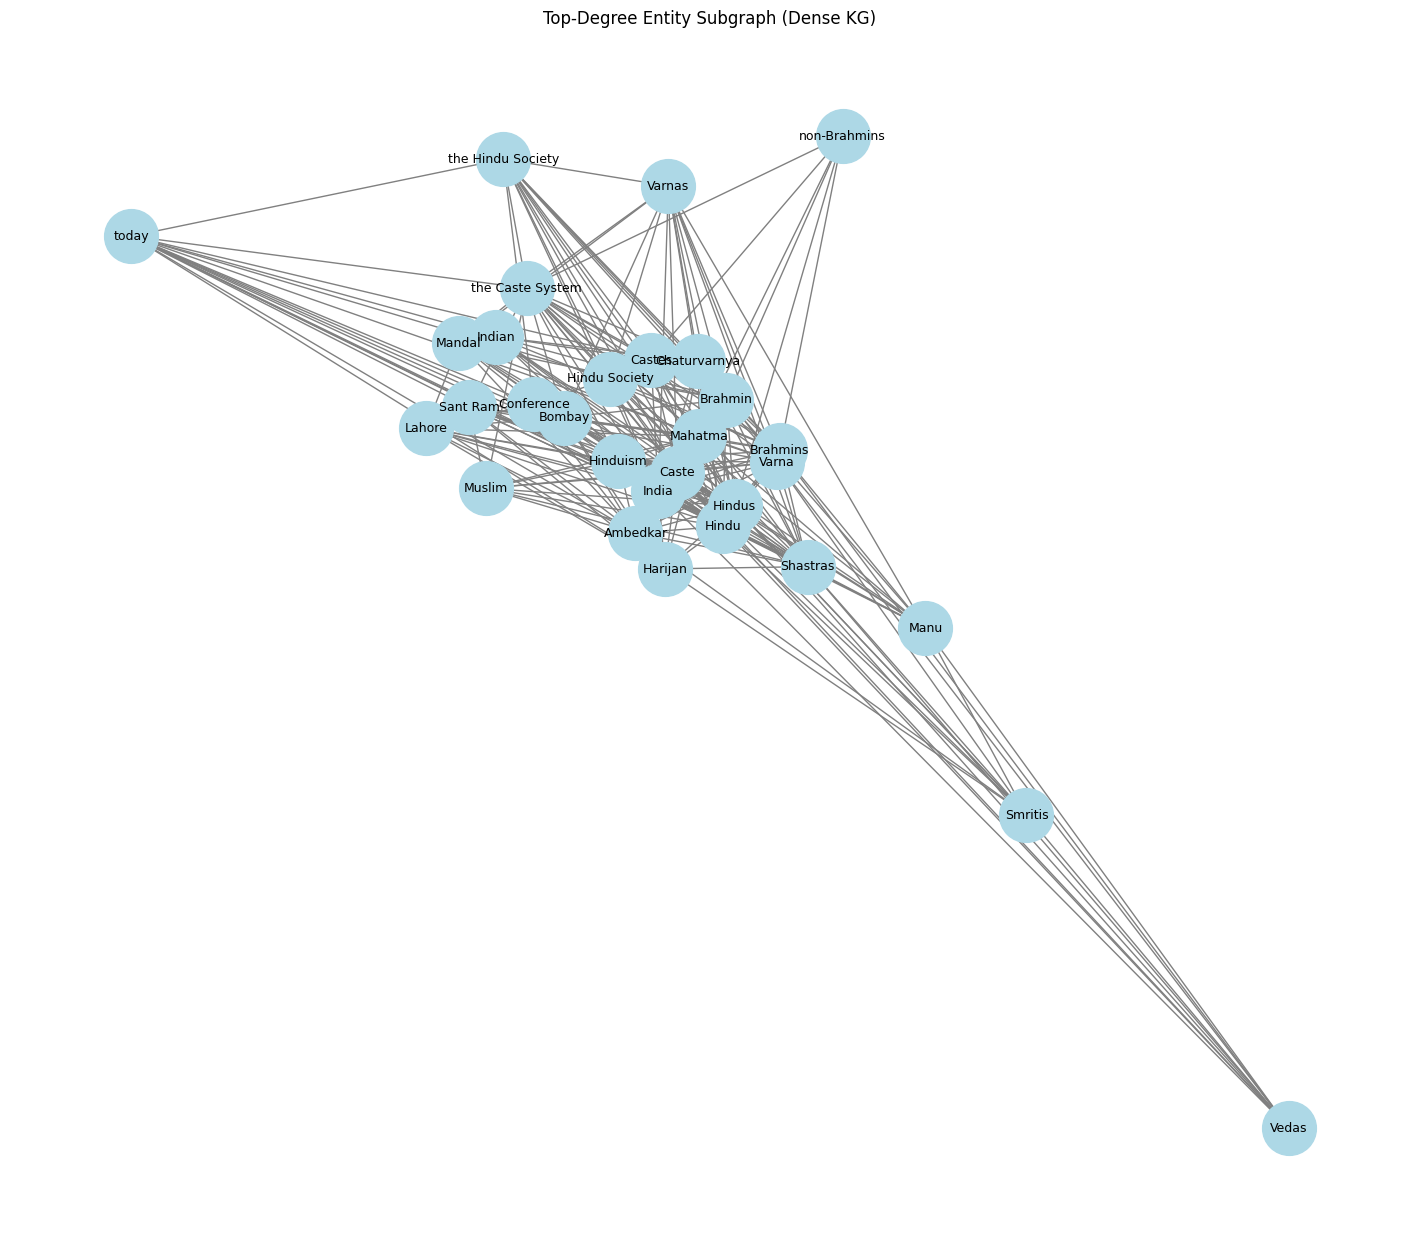

In [22]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# Load dense graph
with open("data/graph/knowledge_graph_dense.gpickle", "rb") as f:
    G = pickle.load(f)

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Take top-N nodes by degree
TOP_N = 30
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:TOP_N]
nodes = [n for n, _ in top_nodes]

H = G.subgraph(nodes)

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(H, seed=42, k=0.4)

nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="lightblue",
    font_size=9,
    edge_color="gray",
    arrows=False
)

plt.title("Top-Degree Entity Subgraph (Dense KG)")
plt.show()


In [23]:
import networkx as nx

G_export = nx.DiGraph()

# Convert node attributes to strings
for node, data in G.nodes(data=True):
    safe_data = {k: ",".join(map(str, v)) if isinstance(v, (list, set)) else v
                 for k, v in data.items()}
    G_export.add_node(node, **safe_data)

# Convert edge attributes to strings
for u, v, data in G.edges(data=True):
    safe_data = {k: ",".join(map(str, v)) if isinstance(v, (list, set)) else v
                 for k, v in data.items()}
    G_export.add_edge(u, v, **safe_data)

nx.write_graphml(G_export, "data/graph/knowledge_graph_dense.graphml")
print("Exported → data/graph/knowledge_graph_dense.graphml")


Exported → data/graph/knowledge_graph_dense.graphml


In [24]:
# src/graph/community_detection.py

import pickle
import json
from pathlib import Path
import networkx as nx
import community as community_louvain
from collections import defaultdict, Counter

# ---------- CONFIG ----------
GRAPH_FILES = {
    "sparse": Path("data/graph/knowledge_graph.gpickle"),
    "dense": Path("data/graph/knowledge_graph_dense.gpickle")
}

OUT_DIR = Path("data/graph")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def run_community_detection(graph_name, graph_path):
    print(f"\n=== Running community detection on {graph_name} graph ===")

    with open(graph_path, "rb") as f:
        G = pickle.load(f)

    # Louvain expects undirected graph
    G_undirected = G.to_undirected()

    print("Nodes:", G_undirected.number_of_nodes())
    print("Edges:", G_undirected.number_of_edges())

    # Run Louvain
    partition = community_louvain.best_partition(
        G_undirected,
        weight="weight",
        resolution=1.0,
        random_state=42
    )

    # Attach community ID to nodes
    nx.set_node_attributes(G_undirected, partition, "community")

    # Analyze communities
    community_nodes = defaultdict(list)
    for node, cid in partition.items():
        community_nodes[cid].append(node)

    stats = {
        "graph": graph_name,
        "num_nodes": G_undirected.number_of_nodes(),
        "num_edges": G_undirected.number_of_edges(),
        "num_communities": len(community_nodes),
        "largest_community_size": max(len(v) for v in community_nodes.values()),
        "smallest_community_size": min(len(v) for v in community_nodes.values()),
    }

    # Build rich community objects (SemRAG-ready)
    community_summaries = {}

    for cid, nodes in community_nodes.items():
        # Sort entities by importance (degree in community subgraph)
        degrees = dict(G_undirected.degree(nodes))
        sorted_entities = [
            n for n, _ in sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        ]

        community_summaries[str(cid)] = {
            "size": len(nodes),
            "entities": sorted_entities,   # ✅ already ordered by importance
            "summary": None,               # placeholder for LLM
            "embedding_index": None        # filled after summarization
        }



    # Save results
    out = {
        "stats": stats,
        "communities": community_summaries
    }

    out_path = OUT_DIR / f"communities_{graph_name}.json"
    with out_path.open("w", encoding="utf-8") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)

    print("Saved →", out_path)
    print("Communities:", stats["num_communities"])
    print("Largest community size:", stats["largest_community_size"])

    return out

if __name__ == "__main__":
    results = {}
    for name, path in GRAPH_FILES.items():
        results[name] = run_community_detection(name, path)



=== Running community detection on sparse graph ===
Nodes: 617
Edges: 20
Saved → data\graph\communities_sparse.json
Communities: 599
Largest community size: 6

=== Running community detection on dense graph ===
Nodes: 617
Edges: 4934
Saved → data\graph\communities_dense.json
Communities: 15
Largest community size: 130


In [25]:
import os
import json
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import numpy as np

from sentence_transformers import SentenceTransformer
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

# ---------- CONFIG ----------
COMMUNITIES_JSON = Path("data/graph/communities_dense.json")
ENTITIES_JSON = Path("data/graph/entities.json")
CHUNKS_JSON = Path("data/processed/chunks.json")
CHUNK_EMB = Path("data/processed/chunks_embeddings.npy")

OUT_EMB_NPY = Path("data/graph/community_summary_embeddings.npy")

LLM_MODEL = "gpt-4o-mini"
EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

TOP_ENTITIES = 20
MAX_SUBCHUNKS_PER_ENTITY = 1
MAX_TOTAL_SUBCHUNKS = 20
MAX_CHARS_PER_SUBCHUNK = 800

# ---------- CLIENTS ----------
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
embedder = SentenceTransformer(EMB_MODEL)

# ---------- HELPERS ----------
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def cosine_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def build_prompt(entities, passages):
    prompt = (
        "You are an expert academic analyst.\n\n"
        "You are given a group of entities extracted from a scholarly text )"
        "and representative text passages related to them (chunks).\n\n"
        "TASK:\n"
        "Write a concise but information-dense community summary that:\n"
        "1. Explains the central theme of this group\n"
        "2. Mentions the most important entities and concepts\n"
        "3. Captures the relationships, story or arguments connecting them\n"
        "4. Is suitable for semantic retrieval (not narrative writing)\n\n"
        "Do NOT add new facts or opinions.\n"
        "Keep the summary factual and compact (150–250 words).\n\n"
        "ENTITIES:\n"
        f"{', '.join(entities)}\n\n"
        "TEXT PASSAGES:\n"
    )

    for p in passages:
        prompt += f"- {p}\n\n"

    return prompt

def call_llm(prompt):
    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return response.choices[0].message.content.strip()

# ---------- MAIN ----------
def generate_community_summaries():
    communities = load_json(COMMUNITIES_JSON)
    entities = load_json(ENTITIES_JSON)
    chunks = load_json(CHUNKS_JSON)["chunks"]
    chunk_embeddings = np.load(CHUNK_EMB)

    # Maps
    chunk_map = {c["chunk_id"]: c for c in chunks}

    entity_chunks = defaultdict(set)
    for e in entities:
        entity_chunks[e["entity"]].add(e["chunk_id"])

    summary_embeddings = []
    emb_index = 0

    print("Generating / embedding community summaries...")

    for cid, comm in tqdm(communities["communities"].items()):
        # ---------- SUMMARY ----------
        if not comm.get("summary"):
            top_entities = comm["entities"][:TOP_ENTITIES]

            member_chunk_ids = set()
            for ent in top_entities:
                member_chunk_ids |= entity_chunks.get(ent, set())

            if not member_chunk_ids:
                continue

            centroid = np.mean(chunk_embeddings[list(member_chunk_ids)], axis=0)

            candidates = []
            for ent in top_entities:
                for cid_ in entity_chunks.get(ent, []):
                    chunk = chunk_map.get(cid_)
                    if not chunk:
                        continue

                    for sub in chunk["subchunks"]:
                        text = sub["text"].strip()
                        if not text:
                            continue

                        emb = embedder.encode(text)
                        score = cosine_sim(emb, centroid)
                        candidates.append((score, text[:MAX_CHARS_PER_SUBCHUNK]))

            candidates.sort(reverse=True, key=lambda x: x[0])
            selected = [t for _, t in candidates[:MAX_TOTAL_SUBCHUNKS]]

            prompt = build_prompt(top_entities, selected)
            comm["summary"] = call_llm(prompt)

        # ---------- EMBEDDING ----------
        summary_vec = embedder.encode(comm["summary"])
        summary_embeddings.append(summary_vec)

        comm["embedding_index"] = emb_index
        emb_index += 1

        # 🔴 ENSURE no embedding stored in JSON
        comm.pop("embedding", None)

    # Save embeddings
    summary_embeddings = np.vstack(summary_embeddings)
    np.save(OUT_EMB_NPY, summary_embeddings)

    # Save updated communities JSON
    with open(COMMUNITIES_JSON, "w", encoding="utf-8") as f:
        json.dump(communities, f, indent=2, ensure_ascii=False)

    print("✅ DONE")
    print("• communities_dense.json updated")
    print("• community_summary_embeddings.npy saved")
    print("• Embedding shape:", summary_embeddings.shape)

if __name__ == "__main__":
    generate_community_summaries()


Generating / embedding community summaries...


100%|██████████| 15/15 [07:01<00:00, 28.08s/it]

✅ DONE
• communities_dense.json updated
• community_summary_embeddings.npy saved
• Embedding shape: (15, 384)


In [1]:

#src/retrieval/local_search.py
import json
import numpy as np
from pathlib import Path
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm

# ----------------- UTILS -----------------
def cosine_sim(a, b):
    if norm(a) == 0 or norm(b) == 0:
        return 0.0
    return float(np.dot(a, b) / (norm(a) * norm(b)))

# ----------------- CONFIG -----------------
ENTITIES_JSON = Path("data/graph/entities.json")
CHUNKS_JSON = Path("data/processed/chunks.json")
CHUNK_EMB = Path("data/processed/chunks_embeddings.npy")

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

TAU_E = 0.35        # query ↔ entity
TAU_D = 0.45        # entity ↔ chunk
TOP_K_ENTITIES = 50
TOP_K_CHUNKS = 5

# ----------------- LOAD -----------------
embedder = SentenceTransformer(EMB_MODEL)

with ENTITIES_JSON.open("r", encoding="utf-8") as f:
    entities = json.load(f)

with CHUNKS_JSON.open("r", encoding="utf-8") as f:
    chunks = json.load(f)["chunks"]

chunk_embeddings = np.load(CHUNK_EMB)

# entity → chunk_ids (graph grounded)
entity_to_chunks = defaultdict(set)
for e in entities:
    entity_to_chunks[e["entity"]].add(e["chunk_id"])

# ----------------- MAIN -----------------
def local_graph_rag_search(query, history=None):
    """
    Implements Equation (4) from SemRAG paper
    """
    q_text = query if history is None else query + " " + history
    q_emb = embedder.encode(q_text)

    # ---- Step 1: Rank entities by similarity ----
    entity_scores = []
    for ent in entity_to_chunks:
        e_emb = embedder.encode(ent)
        sim = cosine_sim(q_emb, e_emb)
        if sim >= TAU_E:
            entity_scores.append((sim, ent))

    entity_scores.sort(reverse=True)
    top_entities = [e for _, e in entity_scores[:TOP_K_ENTITIES]]

    # ---- Step 2: Collect candidate chunks ----
    candidate_chunks = set()
    for ent in top_entities:
        candidate_chunks |= entity_to_chunks[ent]

    # ---- Step 3: Rank chunks ----
    scored_chunks = []
    for cid in candidate_chunks:
        sim = cosine_sim(q_emb, chunk_embeddings[cid])
        if sim >= TAU_D:
            scored_chunks.append((sim, cid))

    scored_chunks.sort(reverse=True)
    top_chunks = scored_chunks[:TOP_K_CHUNKS]

    # ---- Step 4: Return subchunks (points) ----
    results = []
    for score, cid in top_chunks:
        chunk = chunks[cid]
        for sub in chunk["subchunks"]:
            results.append({
                "score": score,
                "text": sub["text"],
                "pages": chunk["pages"],
                "chunk_id": cid
            })

    return {
        "query": query,
        "entities": top_entities,
        "results": results
    }

# ----------------- TEST -----------------
if __name__ == "__main__":
    print("\n=== LOCAL GRAPH RAG SEARCH (Eq. 4) ===\n")

    queries = [
        "What is Ambedkar's critique of the caste system?",
        "What role do Shastras play in Hindu society?",
        "who is Ambedkar"
    ]

    for q in queries:
        out = local_graph_rag_search(q)
        print(f"\n🔎 QUERY: {q}")
        print("Top entities:", out["entities"][:50])

        for i, r in enumerate(out["results"][:5], 1):
            print(f"\nResult {i}")
            print("Score:", round(r["score"], 4))
            print("Pages:", r["pages"])
            print(r["text"][:300], "...")


c:\AmbedkarGPT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== LOCAL GRAPH RAG SEARCH (Eq. 4) ===


🔎 QUERY: What is Ambedkar's critique of the caste system?
Top entities: ['the Caste System', 'The Caste system', 'The Caste System', 'Caste System', 'CASTE Caste', 'the Caste', 'Caste and Untouchability', 'Caste Consciousness', 'Caste', 'CASTE', 'B. R. AMBEDKAR PREFACE', 'Caste Dharma', 'the Caste Hindus', 'the Origin of Caste', 'Ambedkar', 'Caste Hindu Social Reformers', 'Caste versus Class', 'Caste Hindus', 'Castes', 'Castes in India : Their', 'Castes in India', 'Ambedkar’s Indictment', 'the Hindu Society', 'Hindu Society', 'CASTE Shri Sant Ramji', 'non-Brahmin Castes', 'Ketkar', 'Dharma', 'the Hindu Religion', 'Mahabharata', 'VI Caste', 'Hinduism', 'Hindu Maha Sabha', 'Mahabharat', 'the Brahmins of India', 'the Religion of the Shrutis and the Smritis', 'the Hindu Scriptures', 'the Brahmins of Kashmir', 'Maharshi Devendranath Tagore', 'Chaitanya, Jnyandeo, Tukaram, Tiruvalluvar, Ramkrishna Paramahansa', 'Hindus', 'non-Hindu', 'Hindu', 'Sanskr

In [ ]:
#src/retrieval/global_search.py
import json
import numpy as np
from pathlib import Path
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm

# ----------------- UTILS -----------------
def cosine_sim(a, b):
    if norm(a) == 0 or norm(b) == 0:
        return 0.0
    return float(np.dot(a, b) / (norm(a) * norm(b)))

# ----------------- CONFIG -----------------
COMMUNITIES_JSON = Path("data/graph/communities_dense.json")
COMMUNITY_EMB = Path("data/graph/community_summary_embeddings.npy")
CHUNKS_JSON = Path("data/processed/chunks.json")

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

TOP_K_COMMUNITIES = 3
TOP_K_POINTS_PER_COMMUNITY = 3

# ----------------- LOAD -----------------
embedder = SentenceTransformer(EMB_MODEL)

with COMMUNITIES_JSON.open("r", encoding="utf-8") as f:
    communities = json.load(f)["communities"]

community_embeddings = np.load(COMMUNITY_EMB)

with CHUNKS_JSON.open("r", encoding="utf-8") as f:
    chunks = json.load(f)["chunks"]

# ----------------- MAIN -----------------
def global_graph_rag_search(query):
    """
    Implements Equation (5) from SemRAG paper
    """
    q_emb = embedder.encode(query)

    # ---- Step 1: Rank communities ----
    comm_scores = []
    for cid, comm in communities.items():
        emb_idx = comm["embedding_index"]
        sim = cosine_sim(q_emb, community_embeddings[emb_idx])
        comm_scores.append((sim, cid))

    comm_scores.sort(reverse=True)
    top_comms = comm_scores[:TOP_K_COMMUNITIES]

    # ---- Step 2: Retrieve top points per community ----
    all_points = []

    for comm_score, cid in top_comms:
        comm = communities[cid]
        comm_entities = set(comm["entities"])

        local_points = []

        for chunk in chunks:
            for sub in chunk["subchunks"]:
                text = sub["text"]
                if not text:
                    continue

                # entity grounding inside community
                if not any(ent in text for ent in comm_entities):
                    continue

                emb = embedder.encode(text)
                score = cosine_sim(q_emb, emb)
                local_points.append({
                    "score": score,
                    "text": text,
                    "pages": chunk["pages"],
                    "community_id": cid
                })

        local_points.sort(key=lambda x: x["score"], reverse=True)
        all_points.extend(local_points[:TOP_K_POINTS_PER_COMMUNITY])

    # ---- Step 3: Final ranking ----
    all_points.sort(key=lambda x: x["score"], reverse=True)

    return {
        "query": query,
        "communities": [cid for _, cid in top_comms],
        "results": all_points
    }

# ----------------- TEST -----------------
if __name__ == "__main__":
    print("\n=== GLOBAL GRAPH RAG SEARCH (Eq. 5) ===\n")

    queries = [
        "Summarize Ambedkar's views on caste reform",
        "Explain caste in relation to religion and society"
    ]

    for q in queries:
        out = global_graph_rag_search(q)
        print(f"\n🌍 QUERY: {q}")
        print("Top communities:", out["communities"])

        for i, r in enumerate(out["results"][:15], 1):
            print(f"\nResult {i}")
            print("Score:", round(r["score"], 4))
            print("Community:", r["community_id"])
            print("Pages:", r["pages"])
            print(r["text"][:500], "...")



=== GLOBAL GRAPH RAG SEARCH (Eq. 5) ===


🌍 QUERY: Summarize Ambedkar's views on caste reform
Top communities: ['11', '5', '12', '4', '10']

Result 1
Score: 0.672
Community: 5
Pages: [64, 65]
Anything that you will build on the foundations of caste will crack and will never be a whole. 67 ANNIHILATION OF CASTE The only question that remains to be considered is— How to bring about the reform of the Hindu social order ? How to abolish caste ? This is a question of supreme importance. There is a view that in the reform of caste, the first step to take, is to abolish sub-castes. 67 ANNIHILATION OF CASTE The only question that remains to be considered is— How to bring about the reform of  ...

Result 2
Score: 0.672
Community: 12
Pages: [64, 65]
Anything that you will build on the foundations of caste will crack and will never be a whole. 67 ANNIHILATION OF CASTE The only question that remains to be considered is— How to bring about the reform of the Hindu social order ? How to abolish cast

In [ ]:
import os
os.environ["MPLBACKEND"] = "Agg"
import gradio as gr
import ollama
# ---------- IMPORT YOUR EXISTING RETRIEVAL ----------
from src.retrieval.local_search import local_graph_rag_search
from src.retrieval.global_search import global_graph_rag_search

# ---------- CONFIG ----------
LLM_MODEL = "mistral"     # or "llama3"
MAX_LOCAL_EVIDENCE = 5
MAX_GLOBAL_EVIDENCE = 5


# ---------- LLM ANSWER GENERATION ----------
def generate_answer(question, local_results, global_results):
    """
    Generate a grounded answer using Local + Global SemRAG evidence
    """

    local_context = "\n".join(
        f"- {r['text']}" for r in local_results[:MAX_LOCAL_EVIDENCE]
    )

    global_context = "\n".join(
        f"- {r['text']}" for r in global_results[:MAX_GLOBAL_EVIDENCE]
    )

    prompt = f"""
You are an expert academic analyst.

Answer the QUESTION strictly using the CONTEXT below.
Do NOT add external knowledge.
Be factual, concise, and explanatory.

QUESTION:
{question}

LOCAL CONTEXT (Entity-based retrieval):
{local_context}

GLOBAL CONTEXT (Community-based retrieval):
{global_context}

FINAL ANSWER:
"""

    response = ollama.chat(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": prompt}],
        options={"temperature": 0.2}
    )

    return response["message"]["content"].strip()


# ---------- SEMRAG PIPELINE ----------
def semrag_pipeline(question):
    if not question.strip():
        return "Please enter a question.", "", ""

    # ---- Retrieval ----
    local_out = local_graph_rag_search(question)
    global_out = global_graph_rag_search(question)

    # ---- LLM Generation ----
    answer = generate_answer(
        question,
        local_out["results"],
        global_out["results"]
    )

    # ---- Evidence Formatting ----
    local_evidence = "\n\n".join(
        f"• {r['text'][:350]} (pages {r['pages']})"
        for r in local_out["results"][:3]
    )

    global_evidence = "\n\n".join(
        f"• {r['text'][:350]} (pages {r['pages']})"
        for r in global_out["results"][:3]
    )

    return answer, local_evidence, global_evidence


# ---------- GRADIO UI ----------
with gr.Blocks(title="SemRAG Question Answering System") as demo:
    gr.Markdown("""
    # 📘 SemRAG-Based Question Answering System  
    **Local (Entity) + Global (Community) Graph Retrieval with LLM Answer Generation**

    Enter a question related to the document.
    """)

    question_box = gr.Textbox(
        label="Question",
        placeholder="e.g. What is Ambedkar’s critique of the caste system?",
        lines=2
    )

    answer_box = gr.Textbox(label="Final Answer", lines=10)
    local_box = gr.Textbox(label="Local Graph RAG Evidence", lines=8)
    global_box = gr.Textbox(label="Global Graph RAG Evidence", lines=8)

    submit_btn = gr.Button("Generate Answer")

    submit_btn.click(
        fn=semrag_pipeline,
        inputs=question_box,
        outputs=[answer_box, local_box, global_box]
    )

demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
